In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from collections import Counter

In [2]:
# load data
data = pd.read_csv('/Users/zhangzhengyang/Downloads/Ebay Data Challenge/coding here/eBay_ML_Challenge_2025/Listing_Titles.tsv', keep_default_na=False, na_values=None,sep='\t')
data_train = pd.read_csv('/Users/zhangzhengyang/Downloads/Ebay Data Challenge/coding here/eBay_ML_Challenge_2025/Tagged_Titles_Train.tsv', keep_default_na=False, na_values=None,sep='\t')
data_train.head(20)
data_train["Tag"] = data_train["Tag"].replace("", pd.NA).ffill()
print(f"Dimension of training data: {data_train.shape}")
print(f"Dimension of full data: {data.shape}")

Dimension of training data: (56812, 5)
Dimension of full data: (2000000, 3)


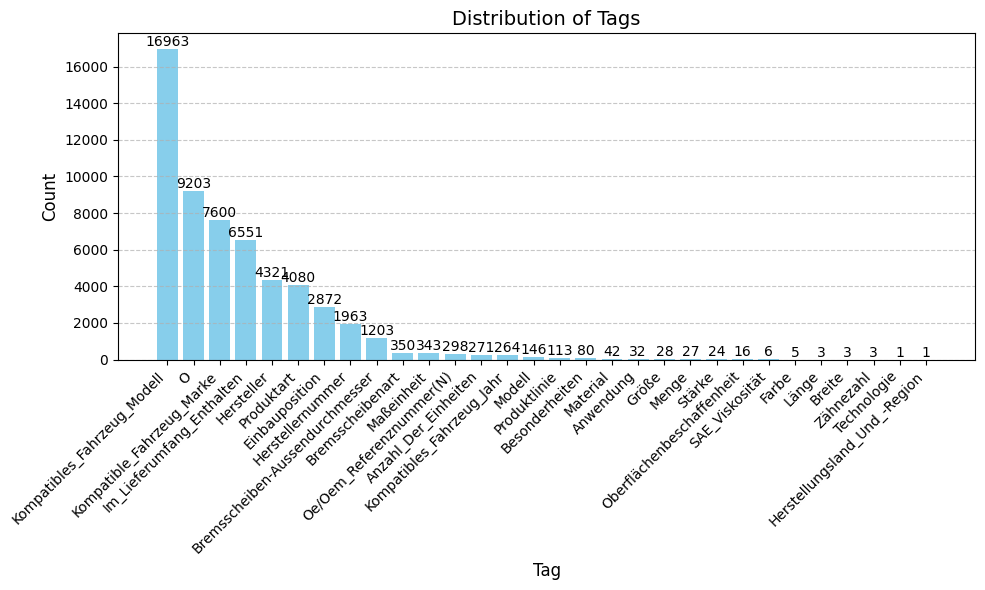

In [3]:
# Count the frequency of each tag
tag_counts = data_train['Tag'].value_counts()

# Create the bar plot (histogram-like)
plt.figure(figsize=(10, 6))
bars = plt.bar(tag_counts.index, tag_counts.values, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Customize the plot
plt.title('Distribution of Tags', fontsize=14)
plt.xlabel('Tag', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()  # Prevent label cutoff
plt.show()

In [4]:
# Data -> sentences + categories
# data_train columns: ["Record Number","Token","Tag","Category"]
sentences = []
categories = []
for rec_id, g in data_train.groupby("Record Number"):
    s = list(zip(g["Token"].tolist(), g["Tag"].tolist()))
    c = int(g["Category"].iloc[0])  # 1 or 2
    sentences.append(s)
    categories.append(c)

# ---------- Vocabularies ----------
words = list(set(data_train["Token"].values)) # all unique tokens in the training dataset.
tags  = list(set(data_train["Tag"].values))
chars = set(ch for w in data_train["Token"].values for ch in w) # Build character vocabulary

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx = {t: i+1 for i, t in enumerate(tags) if t != "PAD"}  # ensure PAD not duplicated
tag2idx["PAD"] = 0
idx2tag = {i: t for t, i in tag2idx.items()}

# Category -> index (embed-friendly)
cat2idx = {1: 0, 2: 1}

char2idx = {ch: i+2 for i, ch in enumerate(chars)}
char2idx["PAD"] = 0
char2idx["UNK"] = 1

While in full data set,

In [5]:
# 1. Tokenize by whitespace
data["Tokens"] = data["Title"].astype(str).str.split()
# 2. Compute title lengths (# of words per title)
data["TitleLen"] = data["Tokens"].apply(len)
# 3. Compute max word length per title
data["MaxWordLenInTitle"] = data["Tokens"].apply(lambda tokens: max((len(w) for w in tokens), default=0))

In [6]:
# 4. Global stats
maxlen_title = data["TitleLen"].max()
max_word_len = data["MaxWordLenInTitle"].max()

print("Max title length (#words):", maxlen_title)
print("Max word length (#chars):", max_word_len)

# 99th percentile for title length
p99_title = np.percentile(data["TitleLen"], 99)
MAXLEN_99 = int(p99_title)

# 99th percentile for word length
p99_word = np.percentile(data["MaxWordLenInTitle"], 99)
MAX_WORD_LEN_99 = int(p99_word)

print("Safe MAXLEN (99th percentile title length):", MAXLEN_99)
print("Safe MAX_WORD_LEN (99th percentile word length):", MAX_WORD_LEN_99)

Max title length (#words): 24
Max word length (#chars): 85
Safe MAXLEN (99th percentile title length): 17
Safe MAX_WORD_LEN (99th percentile word length): 25


Maximum sentence length is acceptable while maximum word length is obviously an outlier.

In [7]:
MAXLEN = maxlen_title # which is 24, 99th percentile is 17
MAX_WORD_LEN = MAX_WORD_LEN_99 # which is 25, maximum is 85

In [8]:
# ---------------- Dataset ----------------
class NERDataset(Dataset):
    def __init__(self, sentences, categories, word2idx, tag2idx, cat2idx, char2idx,
                 maxlen, max_word_len):
        """
        sentences: list of list of (token, tag)
        categories: list of int
        """
        self.sentences = sentences
        self.categories = categories
        self.word2idx = word2idx
        self.tag2idx  = tag2idx
        self.cat2idx  = cat2idx
        self.char2idx = char2idx
        self.maxlen   = maxlen
        self.max_word_len = max_word_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        s = self.sentences[idx]
        c = self.categories[idx]

        # Word & tag IDs
        token_ids = [self.word2idx.get(w, self.word2idx["UNK"]) for w, _ in s]
        tag_ids   = [self.tag2idx[t] for _, t in s]

        # Char IDs
        char_ids = []
        for w, _ in s[:self.maxlen]:
            ch = [self.char2idx.get(ch, self.char2idx["UNK"]) for ch in w[:self.max_word_len]]
            if len(ch) < self.max_word_len:
                ch += [self.char2idx["PAD"]] * (self.max_word_len - len(ch))
            char_ids.append(ch)

        # Padding / truncation
        pad_len = self.maxlen - len(token_ids)
        if pad_len > 0:
            token_ids += [self.word2idx["PAD"]] * pad_len
            tag_ids   += [self.tag2idx["PAD"]] * pad_len
            char_ids  += [[self.char2idx["PAD"]] * self.max_word_len] * pad_len
        else:
            token_ids = token_ids[:self.maxlen]
            tag_ids   = tag_ids[:self.maxlen]
            char_ids  = char_ids[:self.maxlen]

        return (
            torch.tensor(token_ids, dtype=torch.long),        # (MAXLEN,)
            torch.tensor(tag_ids, dtype=torch.long),         # (MAXLEN,)
            torch.tensor(self.cat2idx[c], dtype=torch.long), # ()
            torch.tensor(char_ids, dtype=torch.long)         # (MAXLEN, MAX_WORD_LEN)
        )

In [9]:
# ---------------- Train/Validation Split ----------------
train_sents, val_sents, train_cats, val_cats = train_test_split(
    sentences, categories, test_size=0.1, random_state=42
)

train_dataset = NERDataset(train_sents, train_cats, word2idx, tag2idx, cat2idx, char2idx,
                           maxlen=MAXLEN, max_word_len=MAX_WORD_LEN)
val_dataset = NERDataset(val_sents, val_cats, word2idx, tag2idx, cat2idx, char2idx,
                         maxlen=MAXLEN, max_word_len=MAX_WORD_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# ---------------- CharCNN + BiLSTM ----------------
class CharCNN(nn.Module):
    def __init__(self, char_vocab_size, char_emb_dim=30, char_out_dim=50, kernel_size=3, dropout=0.5):
        super().__init__()
        self.char_emb = nn.Embedding(char_vocab_size, char_emb_dim, padding_idx=0)
        self.conv = nn.Conv1d(char_emb_dim, char_out_dim, kernel_size, padding=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_chars):
        # x_chars: (B, L, max_word_len)
        B, L, W = x_chars.size()
        x = self.char_emb(x_chars)      # (B, L, W, E)
        x = x.view(B*L, W, -1).transpose(1,2)  # (B*L, E, W)
        x = torch.relu(self.conv(x))    # (B*L, char_out_dim, W)
        x, _ = torch.max(x, dim=2)      # (B*L, char_out_dim)
        x = self.dropout(x)
        x = x.view(B, L, -1)            # (B, L, char_out_dim)
        return x


In [11]:
class BiLSTMWithCharCNN(nn.Module):
    def __init__(self, vocab_size, tagset_size, catset_size, char_vocab_size,
                 embedding_dim=100, cat_dim=10, hidden_dim=200,
                 char_emb_dim=30, char_out_dim=50, max_word_len=25, dropout=0.5):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.cat_emb  = nn.Embedding(catset_size, cat_dim)
        self.char_cnn = CharCNN(char_vocab_size, char_emb_dim, char_out_dim, dropout=dropout)
        self.lstm = nn.LSTM(embedding_dim + cat_dim + char_out_dim,
                            hidden_dim//2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_tokens, x_cats, x_chars):
        # Embeddings
        w = self.word_emb(x_tokens)               # (B,L,E)
        c = self.cat_emb(x_cats).unsqueeze(1)     # (B,1,C)
        c = c.expand(-1, x_tokens.size(1), -1)   # (B,L,C)
        ch = self.char_cnn(x_chars)               # (B,L,char_out_dim)
        z = torch.cat([w, c, ch], dim=-1)         # (B,L,E+C+char_out_dim)
        z = self.dropout(z)
        lstm_out, _ = self.lstm(z)                # (B,L,H)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)                # (B,L,T)
        return logits

In [12]:
# ---------------- Evaluation ----------------
PAD_TAG_IDX = tag2idx["PAD"]

def make_mask(tags, pad_idx=PAD_TAG_IDX):
    return tags.ne(pad_idx)

def evaluate_logits(model, data_loader, device):
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x_tokens, y_tags, x_cats, x_chars in data_loader:
            x_tokens, y_tags, x_cats, x_chars = x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
            logits = model(x_tokens, x_cats, x_chars)   # (B,L,T)
            preds = torch.argmax(logits, dim=-1)        # (B,L)
            mask = make_mask(y_tags)
            all_pred.extend(preds[mask].cpu().numpy().tolist())
            all_true.extend(y_tags[mask].cpu().numpy().tolist())
    labels = [i for i in range(len(idx2tag)) if i != PAD_TAG_IDX]
    target_names = [idx2tag[i] for i in labels]
    print(classification_report(all_true, all_pred, labels=labels, target_names=target_names, zero_division=0))

In [13]:
# ---------------- Training BiLSTM + CharCNN ----------------
def train_bilstm_charcnn(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_TAG_IDX)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for x_tokens, y_tags, x_cats, x_chars in train_loader:
            x_tokens, y_tags, x_cats, x_chars = x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
            optimizer.zero_grad()
            logits = model(x_tokens, x_cats, x_chars)
            loss = criterion(logits.view(-1, logits.size(-1)), y_tags.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[BiLSTM+CharCNN] Epoch {ep} | Loss: {total_loss/len(train_loader):.4f}")
        evaluate_logits(model, val_loader, device)
    return model

In [14]:
model = BiLSTMWithCharCNN(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    catset_size=len(cat2idx),
    char_vocab_size=len(char2idx),
    embedding_dim=100,
    cat_dim=10,
    hidden_dim=200,
    char_emb_dim=30,
    char_out_dim=50,
    max_word_len=MAX_WORD_LEN,
    dropout=0.5
)

model_1 = train_bilstm_charcnn(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=1e-3
)


[BiLSTM+CharCNN] Epoch 1 | Loss: 1.4677
                                 precision    recall  f1-score   support

                 Einbauposition       0.95      0.90      0.92       306
    Kompatibles_Fahrzeug_Modell       0.76      0.97      0.85      1657
                      Anwendung       0.00      0.00      0.00         0
                     Hersteller       0.74      0.83      0.78       424
Bremsscheiben-Aussendurchmesser       0.87      0.57      0.69       148
                      Zähnezahl       0.00      0.00      0.00         2
                         Stärke       0.00      0.00      0.00         5
                       Material       0.00      0.00      0.00         5
                          Länge       0.00      0.00      0.00         0
                 SAE_Viskosität       0.00      0.00      0.00         0
                 Besonderheiten       0.00      0.00      0.00         5
   Herstellungsland_Und_-Region       0.00      0.00      0.00         0
          

In [15]:

class BiLSTMCharCNNCRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, catset_size, char_vocab_size,
                 embedding_dim=100, cat_dim=10, hidden_dim=200,
                 char_emb_dim=30, char_out_dim=50, dropout=0.5):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.cat_emb  = nn.Embedding(catset_size, cat_dim)
        self.char_cnn = CharCNN(char_vocab_size, char_emb_dim, char_out_dim, dropout=dropout)
        self.lstm = nn.LSTM(embedding_dim + cat_dim + char_out_dim,
                            hidden_dim//2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_tokens, x_cats, x_chars, tags=None, mask=None):
        w = self.word_emb(x_tokens)
        c = self.cat_emb(x_cats).unsqueeze(1)
        c = c.expand(-1, x_tokens.size(1), -1)
        ch = self.char_cnn(x_chars)
        z = torch.cat([w, c, ch], dim=-1)
        z = self.dropout(z)
        lstm_out, _ = self.lstm(z)
        lstm_out = self.dropout(lstm_out)
        emissions = self.fc(lstm_out)
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction="mean")
            return loss
        else:
            pred_tags = self.crf.decode(emissions, mask=mask)
            return pred_tags

In [16]:
def evaluate_crf(model, data_loader, device):
    """
    Evaluate BiLSTM+CharCNN+CRF model
    """
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x_tokens, y_tags, x_cats, x_chars in data_loader:
            x_tokens, y_tags, x_cats, x_chars = \
                x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
            mask = y_tags.ne(PAD_TAG_IDX)  # True where not PAD
            pred_seqs = model(x_tokens, x_cats, x_chars, tags=None, mask=mask)  # list of list
            # flatten predictions
            for ps, yt, m in zip(pred_seqs, y_tags, mask):
                for pi, ti, mi in zip(ps, yt.tolist(), m.tolist()):
                    if mi:
                        all_pred.append(pi)
                        all_true.append(ti)

    labels = [i for i in range(len(idx2tag)) if i != PAD_TAG_IDX]
    target_names = [idx2tag[i] for i in labels]
    print(classification_report(all_true, all_pred, labels=labels, target_names=target_names, zero_division=0))


In [17]:
def train_bilstm_charcnn_crf(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    patience = 3
    trigger_times = 0

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for x_tokens, y_tags, x_cats, x_chars in train_loader:
            x_tokens, y_tags, x_cats, x_chars = \
                x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
            mask = y_tags.ne(PAD_TAG_IDX)
            optimizer.zero_grad()
            loss = model(x_tokens, x_cats, x_chars, tags=y_tags, mask=mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        print(f"[CRF] Epoch {ep} | Train Loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_tokens, y_tags, x_cats, x_chars in val_loader:
                x_tokens, y_tags, x_cats, x_chars = \
                    x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
                mask = y_tags.ne(PAD_TAG_IDX)
                loss = model(x_tokens, x_cats, x_chars, tags=y_tags, mask=mask)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"[BiLSTM+CharCNN+CRF] Epoch {ep} | Loss: {total_loss/len(train_loader):.4f}")
        evaluate_crf(model, val_loader, device)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
            torch.save(model.state_dict(), "best_crf_model.pt")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    # Load best model
    model.load_state_dict(torch.load("best_crf_model.pt"))
    return model


In [18]:
model_crf = BiLSTMCharCNNCRF(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    catset_size=len(cat2idx),
    char_vocab_size=len(char2idx),
    embedding_dim=100,
    cat_dim=10,
    hidden_dim=200,
    char_emb_dim=30,
    char_out_dim=50,
    dropout=0.5
)

model_2 = train_bilstm_charcnn_crf(
    model=model_crf,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=1e-3
)

[CRF] Epoch 1 | Train Loss: 16.1003
[BiLSTM+CharCNN+CRF] Epoch 1 | Loss: 16.1003
                                 precision    recall  f1-score   support

                 Einbauposition       0.93      0.93      0.93       306
    Kompatibles_Fahrzeug_Modell       0.81      0.95      0.87      1657
                      Anwendung       0.00      0.00      0.00         0
                     Hersteller       0.73      0.82      0.77       424
Bremsscheiben-Aussendurchmesser       0.82      0.59      0.69       148
                      Zähnezahl       0.00      0.00      0.00         2
                         Stärke       0.00      0.00      0.00         5
                       Material       0.00      0.00      0.00         5
                          Länge       0.00      0.00      0.00         0
                 SAE_Viskosität       0.00      0.00      0.00         0
                 Besonderheiten       0.00      0.00      0.00         5
   Herstellungsland_Und_-Region       0.00

In [19]:
def evaluate_aspect_fbeta(model, data_loader, device, idx2tag, beta=0.2):
    """
    Evaluate model using weighted aspect-level F_beta metric.
    
    Args:
        model: trained PyTorch model (BiLSTM, BiLSTM+CharCNN, or BiLSTM+CharCNN+CRF)
        data_loader: DataLoader yielding (x_tokens, y_tags, x_cats, x_chars)
        device: torch device
        idx2tag: dictionary mapping tag index -> tag string
        beta: weight of F_beta (precision-weighted if beta < 1)
    """
    model.eval()
    
    # Store token-level predictions and truths
    all_true, all_pred, all_cats = [], [], []
    
    with torch.no_grad():
        for batch in data_loader:
            # Support both CRF and non-CRF models
            if len(batch) == 4:
                x_tokens, y_tags, x_cats, x_chars = batch
                x_tokens, y_tags, x_cats, x_chars = x_tokens.to(device), y_tags.to(device), x_cats.to(device), x_chars.to(device)
            else:
                x_tokens, y_tags, x_cats = batch
                x_tokens, y_tags, x_cats = x_tokens.to(device), y_tags.to(device), x_cats.to(device)
                x_chars = None
            
            mask = y_tags.ne(tag2idx["PAD"])  # positions not PAD
            
            # Model output
            if hasattr(model, "crf"):  # CRF
                pred_seqs = model(x_tokens, x_cats, x_chars, tags=None, mask=mask)
                for ps, yt, cat, m in zip(pred_seqs, y_tags, x_cats, mask):
                    for pi, ti, mi in zip(ps, yt.tolist(), m.tolist()):
                        if mi:
                            all_pred.append(idx2tag[pi])
                            all_true.append(idx2tag[ti])
                            all_cats.append(cat.item())
            else:  # non-CRF
                logits = model(x_tokens, x_cats, x_chars)  # (B,L,T)
                preds = torch.argmax(logits, dim=-1)
                for pi_seq, ti_seq, cat_seq, m in zip(preds, y_tags, x_cats, mask):
                    for pi, ti, mi in zip(pi_seq.tolist(), ti_seq.tolist(), m.tolist()):
                        if mi:
                            all_pred.append(idx2tag[pi])
                            all_true.append(idx2tag[ti])
                            all_cats.append(cat_seq.item())
    
    # --- Compute weighted F_beta per category ---
    # Exclude "O"
    filtered = [(t, p, c) for t, p, c in zip(all_true, all_pred, all_cats) if t != "O"]
    
    true_counts = defaultdict(Counter)  # {cat_id: Counter(aspect_name -> count)}
    pred_counts = defaultdict(Counter)
    
    for t, p, c in filtered:
        true_counts[c][t] += 1
        if p != "O":
            pred_counts[c][p] += 1
    
    weighted_fb_scores = {}
    for cat_id, aspects in true_counts.items():
        total_in_cat = sum(aspects.values())
        cat_fb = 0.0
        for aspect_name, true_count in aspects.items():
            pred_count = pred_counts[cat_id].get(aspect_name, 0)
            intersection = min(pred_count, true_count)
            
            precision = intersection / pred_count if pred_count > 0 else 0
            recall = intersection / true_count if true_count > 0 else 0
            
            if precision == 0 or recall == 0:
                f_beta = 0
            else:
                f_beta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)
            
            weighted_fb = (true_count / total_in_cat) * f_beta
            cat_fb += weighted_fb
        weighted_fb_scores[cat_id] = cat_fb
    
    # Final competition score = mean across categories
    final_score = np.mean(list(weighted_fb_scores.values()))
    print("Weighted aspect-level F_beta per category:", weighted_fb_scores)
    print("Final weighted F_beta score:", final_score)
    return final_score


In [20]:
# For BiLSTM + CharCNN
evaluate_aspect_fbeta(model_1, val_loader, device, idx2tag, beta=0.2)

# For BiLSTM + CharCNN + CRF
evaluate_aspect_fbeta(model_crf, val_loader, device, idx2tag, beta=0.2)


Weighted aspect-level F_beta per category: {0: 0.9797923532595576, 1: 0.954735769825931}
Final weighted F_beta score: 0.9672640615427444
Weighted aspect-level F_beta per category: {0: 0.9834949669117784, 1: 0.9562442010590392}
Final weighted F_beta score: 0.9698695839854088


0.9698695839854088

In [21]:
def predict_aspects(model, data, word2idx, char2idx, cat2idx, idx2tag, 
                    MAXLEN, MAX_WORD_LEN, device, output_file="predictions.tsv"):
    """
    Run inference on untagged dataset and save predictions as TSV.

    Args:
        model: trained model (BiLSTM+CharCNN or BiLSTM+CharCNN+CRF)
        data: dataframe with ["Record Number", "Category", "Title"]
        word2idx, char2idx, cat2idx, idx2tag: vocabularies
        MAXLEN: max sentence length
        MAX_WORD_LEN: max word length
        device: torch device
        output_file: path to save TSV
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for _, row in data.iterrows():
            rec_id = row["Record Number"]
            cat = row["Category"]
            tokens = str(row["Title"]).split()

            # --- numericalize tokens ---
            token_ids = [word2idx.get(w, word2idx["UNK"]) for w in tokens]
            token_ids = token_ids[:MAXLEN]  # truncate if too long
            pad_len = MAXLEN - len(token_ids)
            token_ids += [word2idx["PAD"]] * pad_len

            # category id
            cat_id = cat2idx[cat]

            # char ids
            char_ids = []
            for w in tokens[:MAXLEN]:
                chars = [char2idx.get(ch, char2idx["UNK"]) for ch in w[:MAX_WORD_LEN]]
                chars += [char2idx["PAD"]] * (MAX_WORD_LEN - len(chars))
                char_ids.append(chars)
            # pad sentence with PAD words
            for _ in range(pad_len):
                char_ids.append([char2idx["PAD"]] * MAX_WORD_LEN)

            # --- convert to tensors ---
            x_tokens = torch.tensor([token_ids], dtype=torch.long, device=device)
            x_cats = torch.tensor([cat_id], dtype=torch.long, device=device)
            x_chars = torch.tensor([char_ids], dtype=torch.long, device=device)

            # --- prediction ---
            if hasattr(model, "crf"):  # CRF model
                mask = x_tokens.ne(word2idx["PAD"])
                pred_seq = model(x_tokens, x_cats, x_chars, tags=None, mask=mask)[0]
            else:  # non-CRF
                logits = model(x_tokens, x_cats, x_chars)  # (1,L,T)
                pred_seq = torch.argmax(logits, dim=-1)[0].tolist()

            # --- collect predictions ---
            for token, tag_idx in zip(tokens, pred_seq[:len(tokens)]):
                tag = idx2tag[tag_idx]
                if tag != "O":  # only keep non-O predictions
                    predictions.append({
                        "Record Number": rec_id,
                        "Category": cat,
                        "Aspect Name": tag,
                        "Aspect Value": token
                    })

    # --- save to TSV ---
    pred_df = pd.DataFrame(predictions)
    pred_df.to_csv(output_file, sep="\t", index=False)
    print(f"Predictions saved to {output_file}")
    return pred_df

In [24]:
pred_df = predict_aspects(
    model=model_1,              
    data=data,                     
    word2idx=word2idx,
    char2idx=char2idx,
    cat2idx=cat2idx,
    idx2tag=idx2tag,
    MAXLEN=MAXLEN,
    MAX_WORD_LEN=MAX_WORD_LEN,
    device=device,
    output_file="predictions_1.tsv"
)

print(pred_df.head())


Predictions saved to predictions_1.tsv
   Record Number  Category                  Aspect Name Aspect Value
0              1         2    Kompatible_Fahrzeug_Marke         MINI
1              1         2  Kompatibles_Fahrzeug_Modell          1.6
2              1         2  Kompatibles_Fahrzeug_Modell      W10B16A
3              1         2  Kompatibles_Fahrzeug_Modell      W11B16A
4              1         2  Kompatibles_Fahrzeug_Modell          R50


In [ ]:
pred_df_crf = predict_aspects(
    model=model_2,               
    data=data,                     
    word2idx=word2idx,
    char2idx=char2idx,
    cat2idx=cat2idx,
    idx2tag=idx2tag,
    MAXLEN=MAXLEN,
    MAX_WORD_LEN=MAX_WORD_LEN,
    device=device,
    output_file="predictions_2.tsv"
)

print(pred_df_crf.head())